In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
sampling_rate = 1e9

#Computation of the number of time sample to simulate for a specific photon bandwidth
single_photon_bandwidth = 4e7
reference_pulse_bandwidth = 1e6

filtered_photon_duration = 5/reference_pulse_bandwidth

n_sample = int(filtered_photon_duration*sampling_rate)
if n_sample%2 == 0:
    n_sample+=1

In [3]:
def make_time_vector(sampling_rate,n_sample):
    return np.linspace(-n_sample/sampling_rate/2,n_sample/sampling_rate/2,n_sample)

In [4]:
#Generation of the single photon wavefunction to measure
time_vector = make_time_vector(sampling_rate,n_sample)
single_photon_wavefunction = np.exp(-time_vector**2*single_photon_bandwidth**2/2)
single_photon_wavefunction = single_photon_wavefunction/np.linalg.norm(single_photon_wavefunction)

(-1e-07, 1e-07)

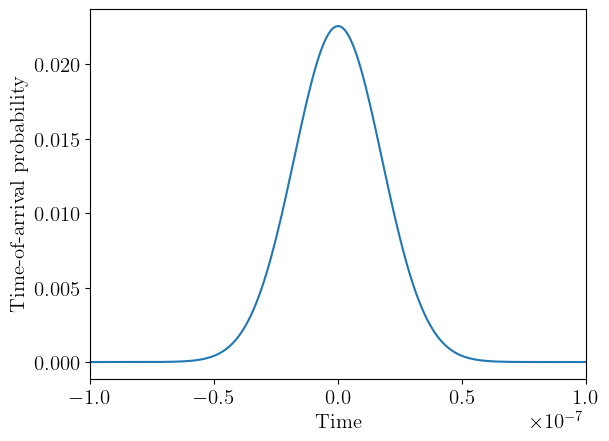

In [5]:
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"rmfamily",
    "font.size":15,
})

plt.plot(time_vector,np.abs(single_photon_wavefunction)**2)
plt.xlabel("Time",fontfamily="rmfamily")
plt.ylabel("Time-of-arrival probability")
plt.xlim(-1e-7,1e-7)

In [6]:
#Simulation of the EOM
EOM_loss_dB = 7
EOM_loss_amp = 10**(-EOM_loss_dB/20)
frequency_offset = sampling_rate/int(sampling_rate/(2*single_photon_bandwidth))
EOM_freq = sampling_rate/int(sampling_rate/frequency_offset)
EOM_single_photon = EOM_loss_amp*single_photon_wavefunction*np.exp(1j*np.sin(2*np.pi*time_vector*EOM_freq))

In [7]:
def make_freq_vector(sampling_rate,n_sample):
    return np.linspace(-sampling_rate/2,sampling_rate/2,n_sample)

In [8]:
freq_vector=make_freq_vector(sampling_rate,n_sample)

Text(0, 0.5, 'Spectrum')

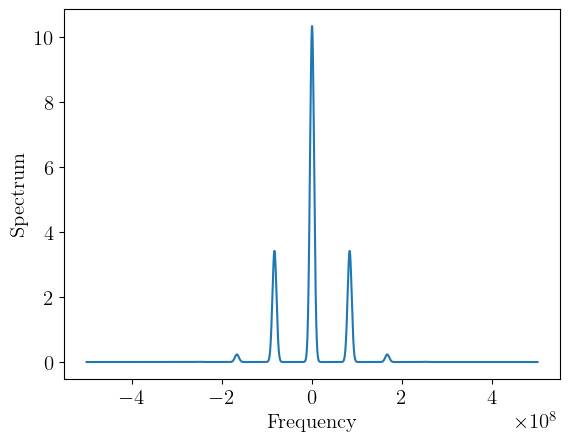

In [9]:
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"rmfamily",
    "font.size":15,
})

plt.plot(freq_vector,np.abs(np.fft.fftshift(np.fft.fft(EOM_single_photon)))**2)
plt.xlabel("Frequency",fontfamily="rmfamily")
plt.ylabel("Spectrum")

In [10]:
#Simulation of the first filter isolating only the peak 0 and 1
filter_1_min_freq = -3/2*single_photon_bandwidth/2
filter_1_max_freq = frequency_offset + 3/2*single_photon_bandwidth/2

filter_1_min_bin = int(filter_1_min_freq/sampling_rate*n_sample)+n_sample
filter_1_max_bin = int(filter_1_max_freq/sampling_rate*n_sample)

freq_filter_1_single_photon = np.zeros(n_sample,dtype=complex)
freq_filter_1_single_photon[filter_1_min_bin:n_sample] = np.fft.fft(EOM_single_photon)[filter_1_min_bin:n_sample]
freq_filter_1_single_photon[0:filter_1_max_bin] = np.fft.fft(EOM_single_photon)[0:filter_1_max_bin]
filter_1_single_photon = np.fft.ifft(freq_filter_1_single_photon)

Text(0, 0.5, 'Spectrum')

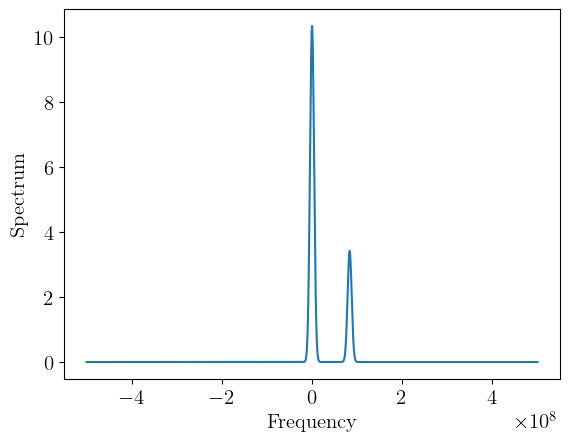

In [11]:
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"rmfamily",
    "font.size":15,
})

plt.plot(freq_vector,np.abs(np.fft.fftshift(np.fft.fft(filter_1_single_photon)))**2)
plt.xlabel("Frequency",fontfamily="rmfamily")
plt.ylabel("Spectrum")

In [12]:
#Simulation of the second filter shaping the 0 component into a monochromatic contribution and attenuating the 1 component
filter_2_ref_min_freq = -reference_pulse_bandwidth/2
filter_2_ref_max_freq = reference_pulse_bandwidth/2

filter_2_ref_min_bin = int(filter_2_ref_min_freq/sampling_rate*n_sample)+n_sample
filter_2_ref_max_bin = int(filter_2_ref_max_freq/sampling_rate*n_sample)

filter_2_min_freq = frequency_offset-3/2*single_photon_bandwidth/2
filter_2_max_freq = frequency_offset+3/2*single_photon_bandwidth/2

filter_2_min_bin = int(filter_2_min_freq/sampling_rate*n_sample)
filter_2_max_bin = int(filter_2_max_freq/sampling_rate*n_sample)

filter_2_att = 1/25

freq_filter_2_single_photon = np.zeros(n_sample,dtype=complex)
freq_filter_2_single_photon[filter_2_ref_min_bin:n_sample] = np.fft.fft(filter_1_single_photon)[filter_2_ref_min_bin:n_sample]
freq_filter_2_single_photon[0:filter_2_ref_max_bin] = np.fft.fft(filter_1_single_photon)[0:filter_2_ref_max_bin]
freq_filter_2_single_photon[filter_2_min_bin:filter_2_max_bin] = filter_2_att*np.fft.fft(filter_1_single_photon)[filter_2_min_bin:filter_2_max_bin]
filter_2_single_photon = np.fft.ifft(freq_filter_2_single_photon)

Text(0, 0.5, 'Spectrum (log scale)')

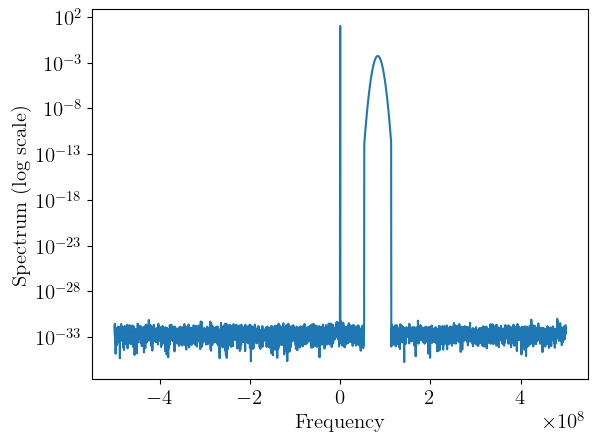

In [13]:
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"rmfamily",
    "font.size":15,
})

plt.semilogy(freq_vector,np.abs(np.fft.fftshift(np.fft.fft(filter_2_single_photon)))**2)
plt.xlabel("Frequency",fontfamily="rmfamily")
plt.ylabel("Spectrum (log scale)")

In [14]:
#We truncate the time wavefunction to only keep the part when the monochromatic contribution is constant
single_photon_duration = 5/single_photon_bandwidth

n_sample_trunc = int(single_photon_duration*sampling_rate)
if n_sample_trunc%2==0:
    n_sample_trunc = n_sample_trunc+1

filtered_single_photon_trunc = filter_2_single_photon[int(n_sample/2) - int(n_sample_trunc/2):int(n_sample/2)+int(n_sample_trunc/2)+1]

single_photon_trunc = single_photon_wavefunction[int(n_sample/2) - int(n_sample_trunc/2):int(n_sample/2)+int(n_sample_trunc/2)+1]

time_vector_trunc = make_time_vector(sampling_rate,n_sample_trunc)
freq_vector_trunc = make_freq_vector(sampling_rate,n_sample_trunc)

In [15]:
#Characteristics of the single photon detector
dark_count_rate = 1e1
single_photon_detector_efficiency = 70/100
jitter_time = 1e-10

In [16]:
#Given a probability distribution return a index associated to a realization of the random variable
def time_of_arrival_proba(probability_distribution):
    n_sample = np.shape(probability_distribution)[0]
    cumulative_function = np.cumsum(probability_distribution)
    total_proba = np.sum(probability_distribution) #Consider the case here the probability sums to less than one i.e. in the case where the result can be lost
    random_proba = np.random.rand()
    if random_proba>total_proba:
        return -1 #If the measurement is lost
    random_index = n_sample-1
    for index in range(n_sample):
        if random_proba<cumulative_function[index]:
            random_index=index
            break
    return random_index

In [17]:
#Function that simulates a detection with a single photon detector
def time_of_arrival_histogram(wavefunction, n_monte_carlo, dark_count_rate,sampling_rate,jitter_time):
    n_sample = np.shape(wavefunction)[0]
    exp_histogram = np.ones(n_sample) #initialize with one everywhere to have non zero probability for the application of the logarithm to be robust
    probability_photon = sp.ndimage.gaussian_filter(np.abs(wavefunction)**2,sigma=jitter_time*sampling_rate) #Time-of-arrival probability distribution to approximate with the histogram
    probability_dark_count = 1-np.exp(-dark_count_rate/sampling_rate) #Probability of recording a dark count at each time slot
    for monte_carlo_index in range(n_monte_carlo):
        dark_count_tab = np.random.binomial(1,probability_dark_count,n_sample) #precompute the slots containing a dark count
        photon_index = time_of_arrival_proba(probability_photon) #Index of the time slot for the detection event
        exp_histogram = exp_histogram+dark_count_tab
        if photon_index>=0:
            if dark_count_tab[photon_index]<1:
                exp_histogram[photon_index] += 1
    return exp_histogram 

In [18]:
def hilbert_transform(x):
    n_sample = np.shape(x)[0]
    if n_sample%2 == 0:
        error("Number of sample even")
        return
    bin_0= int((n_sample-1)/2)
    X = np.fft.fft(x)
    X[bin_0] = 0
    X[bin_0+1:n_sample] = - X[bin_0+1:n_sample]
    return -1j*np.fft.ifft(X)

In [19]:
#Example for one scenario
freq_exp_single_photon_shifted_trunc = np.zeros(n_sample_trunc,dtype=complex)
exp_min_bin = int(filter_2_min_freq/sampling_rate*n_sample_trunc)
exp_single_photon = np.zeros(n_sample,dtype=complex)
#Estimation of the time-of-arrival distribution
n_monte_carlo = 1000000
exp_histogram = time_of_arrival_histogram(np.sqrt(single_photon_detector_efficiency)*filtered_single_photon_trunc,n_monte_carlo,dark_count_rate,sampling_rate,jitter_time)
exp_probability = exp_histogram/np.sum(exp_histogram)

#Kramers-Kronig detection DSP
log_probability = np.log(exp_probability)
exp_phase=np.real(hilbert_transform(log_probability/2))
exp_filtered_single_photon_trunc = np.sqrt(exp_probability)*np.exp(1j*exp_phase)

#Filtering to recover to original wavefunction
freq_exp_single_photon_shifted_trunc[exp_min_bin:int((n_sample-1)/2)] = np.fft.fft(exp_filtered_single_photon_trunc)[exp_min_bin:int((n_sample-1)/2)]
exp_single_photon_trunc = np.fft.ifft(freq_exp_single_photon_shifted_trunc)*np.exp(-1j*2*np.pi*frequency_offset*time_vector_trunc)
exp_single_photon_trunc = exp_single_photon_trunc/np.linalg.norm(exp_single_photon_trunc)

#Compute the fidelity
exp_single_photon[int(n_sample/2)-int(n_sample_trunc/2):int(n_sample/2)+int(n_sample_trunc/2)+1] = exp_single_photon_trunc
fidelity = np.abs(np.sum(np.multiply(np.conj(exp_single_photon),exp_single_photon)))**2

In [20]:
fidelity

np.float64(1.0)

In [21]:
#Setup the Monte Carlo experiment
n_parameters = 10
parameter_table = np.logspace(7,9,n_parameters) #Number of measurements to test

fidelity_tab = np.zeros(n_parameters)

In [22]:
#Put true to run the next cell
run_simulation = True

In [ ]:
freq_exp_single_photon_shifted_trunc = np.zeros(n_sample_trunc,dtype=complex)
exp_min_bin = int(filter_2_min_freq/sampling_rate*n_sample_trunc)
frequency_shift = sampling_rate/int(sampling_rate/frequency_offset)
exp_single_photon = np.zeros(n_sample,dtype=complex)
if run_simulation:
    for parameter_index in range(n_parameters):
        #Estimation of the time-of-arrival distribution
        n_monte_carlo = int(parameter_table[parameter_index])
        exp_histogram = time_of_arrival_histogram(np.sqrt(single_photon_detector_efficiency)*filtered_single_photon_trunc,n_monte_carlo,dark_count_rate,sampling_rate,jitter_time)
        exp_probability = exp_histogram/np.sum(exp_histogram)

        #Kramers-Kronig detection DSP
        log_probability = np.log(exp_probability)
        exp_phase=np.real(hilbert_transform(log_probability/2))
        exp_filtered_single_photon_trunc = np.sqrt(exp_probability)*np.exp(1j*exp_phase)

        #Filtering to recover to original wavefunction
        freq_exp_single_photon_shifted_trunc[exp_min_bin:int((n_sample-1)/2)] = np.fft.fft(exp_filtered_single_photon_trunc)[exp_min_bin:int((n_sample-1)/2)]
        exp_single_photon_trunc = np.fft.ifft(freq_exp_single_photon_shifted_trunc)*np.exp(-1j*2*np.pi*frequency_shift*time_vector_trunc)
        exp_single_photon_trunc = exp_single_photon_trunc/np.linalg.norm(exp_single_photon_trunc)

        #Compute the fidelity
        exp_single_photon[int(n_sample/2)-int(n_sample_trunc/2):int(n_sample/2)+int(n_sample_trunc/2)+1] = exp_single_photon_trunc
        fidelity_tab[parameter_index] = np.abs(np.sum(np.multiply(np.conj(exp_single_photon),single_photon_wavefunction)))**2

In [ ]:
if run_simulation:
    plt.rcParams.update({
        "text.usetex":True,
        "font.family":"rmfamily",
        "font.size":15,
    })

    plt.semilogx(parameter_table,fidelity_tab)
    plt.xlabel("Number of measurements")
    plt.ylabel("Fidelity")